# Notes

Space for running small experiments on the code to check whether and how things work.

## 1. Recurrent Neural Network
When passing a sequence of inputs over time to the neural network, does it matter whether the input
- is given staggered or
- is given all at once?

In [13]:
from simulation import Params
from agent import Rnn
import torch
params = Params.from_json('parameters.json')

rnn = Rnn(params)

initial_hidden_state = None
first_input = torch.tensor([[-0.3, 1.0, 0.2]], dtype=torch.float32)
second_input = torch.tensor([[0.7, 0.3, 0.5]], dtype=torch.float32)
third_input = torch.tensor([[-0.5, 0.8, 0.7]], dtype=torch.float32)
first_output, first_hidden_state = rnn(first_input, initial_hidden_state)
second_output, second_hidden_state = rnn(second_input, first_hidden_state)
third_output, third_hidden_state = rnn(third_input, second_hidden_state)

sequence_input = torch.tensor([
    [-0.3, 1.0, 0.2],
    [0.7, 0.3, 0.5],
    [-0.5, 0.8, 0.7]
], dtype=torch.float32)
output, sequence_hidden_state = rnn(sequence_input, initial_hidden_state)
print('1. step output:', first_output)
print('2. step output:', second_output)
print('3. step output:', third_output, '=', output, 'sequence output')
print('first hidden state:', first_hidden_state)
print('second hidden state:', second_hidden_state)
print('third hidden state:', third_hidden_state, '=', sequence_hidden_state, 'sequence hidden state')

1. step output: tensor([ 0.2207, -0.3637])
2. step output: tensor([ 0.0350, -0.1531])
3. step output: tensor([ 0.2138, -0.3836]) = tensor([ 0.2138, -0.3836]) sequence output
first hidden state: tensor([[-0.1184,  0.5387,  0.1035,  0.2859]])
second hidden state: tensor([[-0.1107, -0.1639, -0.1030, -0.1608]])
third hidden state: tensor([[-0.4286,  0.7053,  0.0857,  0.1454]]) = tensor([[-0.4286,  0.7053,  0.0857,  0.1454]]) sequence hidden state


-> it does not matter whether the inputs are passed in a staggered fashion or all at once.

Regarding the output of the Recurrent hidden layer:

In [14]:
from simulation import Params
from agent import Rnn
import torch

params = Params.from_json('parameters.json')
model = Rnn(params)
input_data = torch.rand(1, model.input_size)
print('input_data:', input_data)
hidden_output, hidden_state = model.forward(input_data, torch.zeros(1, model.hidden_size))
print('hidden_output:', hidden_output)
print('hidden_state:', hidden_state)


input_data: tensor([[0.7541, 0.3865, 0.8412]])
hidden_output: tensor([-0.2169,  0.5796])
hidden_state: tensor([[ 0.4013, -0.5155,  0.0766, -0.4063]])


The forward function returns the output from the hidden layer to the output layer and the updated hidden state.

## 3. Test Environment Function
**Objective:** Test the get_closest_food function visually. 

Animating 1/1:  67%|██████▋   | 2/3 [00:14<00:07,  7.16s/frame]

closest_position: [59.88288796 34.17555591]
closest_distance: 3.377335501781934


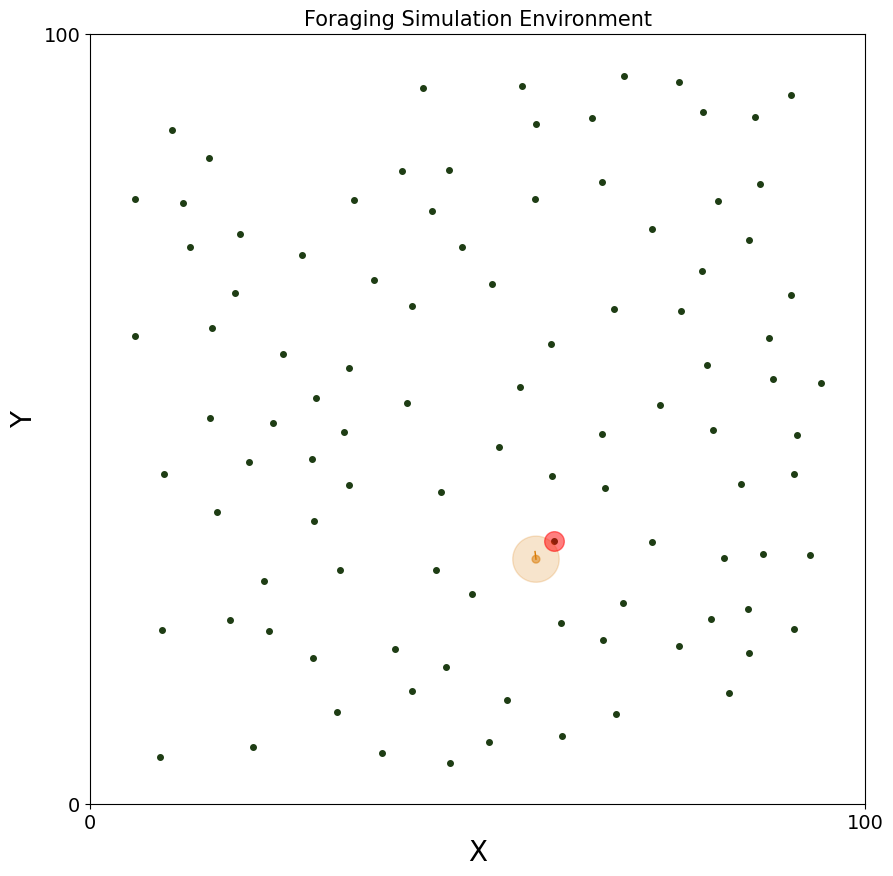

In [15]:
from environment import Environment
from agent import RnnAgent, Rnn
from simulation import Params
from visualization import visualize_state
import matplotlib.pyplot as plt
import numpy as np

params = Params.from_json('parameters.json')
params.num_food = 100
params.size = 100
environment = Environment(params)
model = Rnn(params)
agent = RnnAgent(params, model)

# extra test for periodic boundaries
# agent.position = np.array([environment.size - 10, environment.size/2])
# agent.food_mask = np.zeros(2, dtype=bool)
# environment.food_positions = np.asarray([[environment.size/3, environment.size/2], [10, environment.size/2]])
# environment.num_food = 2

ax = visualize_state(environment, [agent])

agent.perception_radius = environment.size
closest_position, closest_distance, closest_index = environment.get_closest_food(agent)
print('closest_position:', closest_position)
print('closest_distance:', closest_distance)

ax.scatter(closest_position[0], closest_position[1], color='red', s=200, alpha=0.5)
plt.show()

## 4. Test Agent Helper Functions 

In [16]:
from agent import vector_to_angle, calculate_angle_difference
import numpy as np

assert(vector_to_angle(np.asarray([1, 0]))/np.pi == 0.0)
assert(vector_to_angle(np.asarray([0, 1]))/np.pi == 0.5)
assert(vector_to_angle(np.asarray([-1, 0]))/np.pi == 1.0)
assert(vector_to_angle(np.asarray([0, -1]))/np.pi == -0.5)
assert(vector_to_angle(np.asarray([1, 1]))/np.pi == 0.25)
assert(vector_to_angle(np.asarray([0, 0]))/np.pi == 0.0)
assert(calculate_angle_difference(np.pi, np.pi*0.5) == 0.5*np.pi)
assert(calculate_angle_difference(np.pi*0.5, np.pi) == -0.5*np.pi)
assert(calculate_angle_difference(np.pi*0.5, 3*np.pi/2) == -np.pi)
assert(calculate_angle_difference(0, 0) == 0)
assert(calculate_angle_difference(0, 2*np.pi) == 0)
assert(calculate_angle_difference(9/10*np.pi, 1/10*np.pi) == 8/10*np.pi)
assert(calculate_angle_difference(1/10*np.pi, 9/10*np.pi) == -8/10*np.pi)
assert(calculate_angle_difference(1/10*np.pi, 19/10*np.pi) == 0.2*np.pi)
assert(calculate_angle_difference(0, np.pi) == -np.pi)
assert(calculate_angle_difference(np.pi, 3*np.pi/2) == -np.pi/2)

# 5. Test Agent Food Consumption

**Objective**: Test whether agents take up all food particles on their path.

Independent of their velocity, agents pick up all food particles that they stepped over.

Animating 1/1:  60%|██████    | 3/5 [00:00<00:00, 13.51frame/s]

Safed animation under:
/home/lewin/levy-agent-simulation/data/experiments
1.0


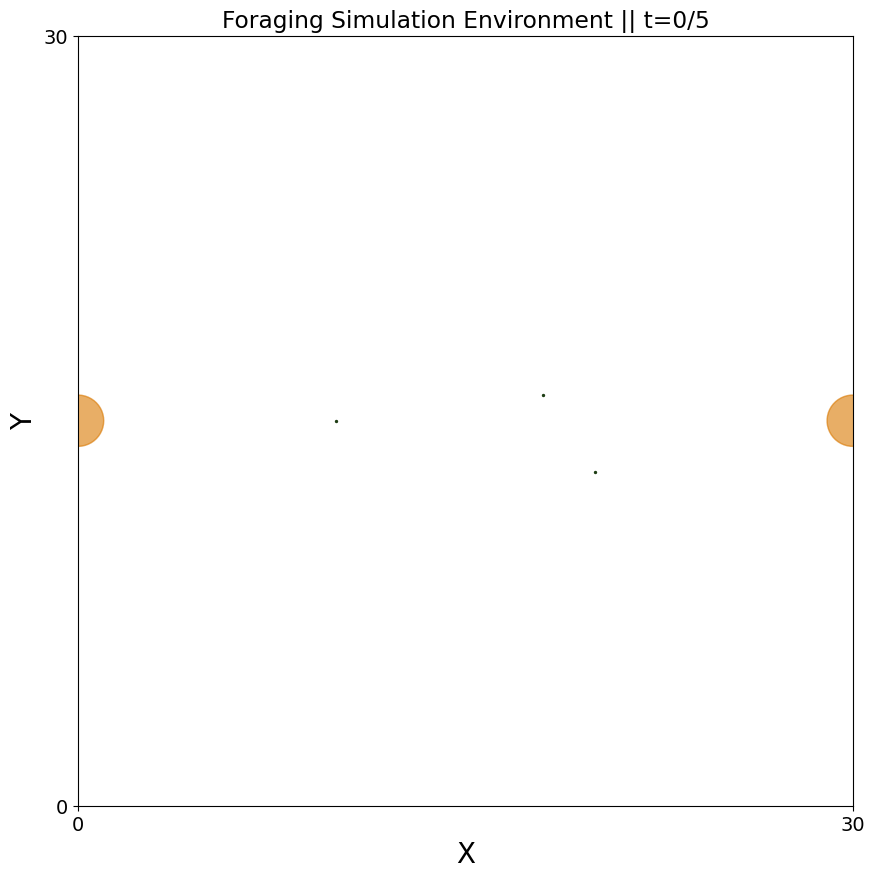

Animating 1/1:  60%|██████    | 3/5 [00:16<00:00, 13.51frame/s]

In [ ]:
from agent import BallisticAgent
from environment import Environment
from simulation import Simulation, Params
from data_io import initialize_epoch_data
from visualization import animate_single_iteration
import numpy as np

SIZE = 30
EAT_RADIUS = 1
FOOD_POSITIONS = np.array([[SIZE/3, SIZE/2], 
                           [3*SIZE/5, SIZE/2+EAT_RADIUS], 
                           [2*SIZE/3, SIZE/2-2*EAT_RADIUS]])
NUM_FOOD = len(FOOD_POSITIONS)
VELOCITY = 1
NUM_ITERATIONS = 1
POPULATION_SIZE = 1
DELTA_T = SIZE/2
TOTAL_TIME = 4*DELTA_T

folder = 'experiments'

params = Params(
    num_food = NUM_FOOD,
    size = SIZE,
    velocity = VELOCITY,
    eat_radius = EAT_RADIUS,
    iterations_per_epoch = NUM_ITERATIONS,
    num_epochs = 1,
    population_size = POPULATION_SIZE,
    total_time = TOTAL_TIME,
    delta_t = DELTA_T,
    empty = False,
    border_buffer = 2,
    food_buffer = 2,
    perception_radius = EAT_RADIUS,
)

environment = Environment(params)
environment.food_positions = FOOD_POSITIONS
environment.num_food = NUM_FOOD

data = initialize_epoch_data(params)
agent = BallisticAgent(params)
agent.direction = 0
agent.position = np.array([0, params.size/2])
population = [agent]

sim = Simulation(params, BallisticAgent)
population[0].reset = lambda: None
sim.run_iteration(population, environment)
animate_single_iteration(0, environment, params, sim.data, 'experiments', 'test_food_consumption', 0, save=True)
print(sim.data['ate'].values.sum())
# if check_path would be periodic boundary safe it would be able to detect the second food particle as well